In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

In [ ]:
# use the data which independent variables are filled by KNN and dependent variables are filled by proxy model.
df_raw = pd.read_csv('/content/drive/My Drive/MLPS_final_project/data/covid_fill_x_y.csv')
df_raw.head()

,geo_value,smoothed_wspent_time_1d,smoothed_wtested_14d,smoothed_wpublic_transit_1d,smoothed_wworried_become_ill,smoothed_wshop_1d,smoothed_wtested_positive_14d,smoothed_wwork_outside_home_1d,smoothed_wcli,smoothed_wvaccine_likely_friends,...,year,month,day,weekday,is_pseudo_covid_positive,time_value,smoothed_wcovid_vaccinated,is_pseudo_vaccinated,state_fips,state
0,1000.0,34.412959,12.541558,1.464798,65.771681,52.854667,29.288429,30.487852,3.244379,28.469582,...,2021,1,7,3,0,2021-01-07,2.638200,0,1,Alabama
1,2000.0,31.031930,23.187988,5.247612,54.332976,52.948188,8.843686,31.242179,0.421245,29.240819,...,2021,1,7,3,0,2021-01-07,15.910167,0,2,Alaska
2,4000.0,33.894471,15.813525,1.670934,70.449040,52.224064,30.302464,26.614385,1.401254,38.028305,...,2021,1,7,3,0,2021-01-07,4.715310,0,4,Arizona
3,4013.0,30.674532,16.170044,3.106310,68.928567,50.983665,22.710935,24.467235,2.082898,34.448458,...,2021,1,7,3,0,2021-01-07,4.005679,0,4,Arizona
4,4019.0,30.489939,16.193151,2.943076,69.579201,52.706816,21.912277,24.371077,1.306140,36.117471,...,2021,1,7,3,0,2021-01-07,6.249659,0,4,Arizona


In [ ]:
df_raw.dtypes

,0
geo_value,float64
smoothed_wspent_time_1d,float64
smoothed_wtested_14d,float64
smoothed_wpublic_transit_1d,float64
smoothed_wworried_become_ill,float64
smoothed_wshop_1d,float64
smoothed_wtested_positive_14d,float64
smoothed_wwork_outside_home_1d,float64
smoothed_wcli,float64
smoothed_wvaccine_likely_friends,float64


# 1. data preprocessing

- remove: 'smoothed_wcovid_vaccinated','is_pseudo_vaccinated','state_fips','geo_value', 'time_value', 'year', 'is_pseudo_covid_positive'
- transform:
  - one-hot encoding: weekday, state
  - Convert day to cyclic features: Using sin() and cos() transforms for the day feature allows the model to capture its cyclical nature, ensuring that the beginning and end of the month are treated as adjacent rather than distant values.

In [ ]:
df = df_raw.drop(columns=['smoothed_wcovid_vaccinated','is_pseudo_vaccinated','state_fips','geo_value'])
df.dtypes

,0
smoothed_wspent_time_1d,float64
smoothed_wtested_14d,float64
smoothed_wpublic_transit_1d,float64
smoothed_wworried_become_ill,float64
smoothed_wshop_1d,float64
smoothed_wtested_positive_14d,float64
smoothed_wwork_outside_home_1d,float64
smoothed_wcli,float64
smoothed_wvaccine_likely_friends,float64
smoothed_wrestaurant_1d,float64


In [ ]:
df['is_pseudo_covid_positive'].value_counts(normalize=True)

,proportion
is_pseudo_covid_positive,
1,0.844143
0,0.155857


In [ ]:
df['weekday'].unique()

array([3, 4, 5, 6, 0, 1, 2])

In [ ]:
def preprocess_data(df):
    # Remove 'time_value'
    df = df.drop(columns=['time_value', 'year'])

    # Convert day to cyclic features
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df = df.drop(columns='day')

    # One-hot encode 'state', 'weekday'
    df = pd.get_dummies(df, columns=['weekday', 'state'])

    return df

## Evaluation Method
**data split: stratified by `is_pseudo_covid_positive`**

| Split Portion  | Purpose                                           | Evaluation Strategy                               |
|----------------|---------------------------------------------------|---------------------------------------------------|
| **80% Train**  | Used for training & validation via **K-Fold CV**  | K-Fold C |
| **20% Test**   | Held out for final evaluation                     | Final test set                      |

In [ ]:
def evaluate_model_kfold(model, X, y, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mae_scores, rmse_scores, r2_scores = [], [], []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        mae_scores.append(mean_absolute_error(y_val, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, preds)))
        r2_scores.append(r2_score(y_val, preds))

    return {
        'MAE': f"{np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}",
        'RMSE': f"{np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}",
        'R2': f"{np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}"
    }

In [ ]:
def evaluate_model_test(model, X_test, y_test):
    preds = model.predict(X_test)
    return {
        'MAE': f"{mean_absolute_error(y_test, preds):.4f}",
        'RMSE': f"{np.sqrt(mean_squared_error(y_test, preds)):.4f}",
        'R2': f"{r2_score(y_test, preds):.4f}"
    }

In [ ]:
def evaluate_on_pseudo_split(model, X_test, y_test, pseudo_flag):
    results = {}
    for label, name in zip([0, 1], ['Real Data (is_pseudo=0)', 'Proxy Data (is_pseudo=1)']):
        mask = (pseudo_flag == label)
        preds = model.predict(X_test[mask])
        results[name] = {
            'MAE': f"{mean_absolute_error(y_test[mask], preds):.4f}",
            'RMSE': f"{np.sqrt(mean_squared_error(y_test[mask], preds)):.4f}",
            'R2': f"{r2_score(y_test[mask], preds):.4f}"
        }
    return pd.DataFrame(results).T

In [ ]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} – Actual vs. Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"{model_name} – Residual Distribution")
    plt.xlabel("Residuals")

    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, linestyle='--', color='red')
    plt.title(f"{model_name} – Residuals vs. Fitted")
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")

    plt.tight_layout()
    plt.show()


# Modeling

In [ ]:
def run_pipeline(df, target='smoothed_wtested_positive_14d'):
    # data preprocessing
    df_cleaned = preprocess_data(df)

    # split data
    excluded = ['is_pseudo_covid_positive', target]
    X = df_cleaned.drop(columns=excluded)
    y = df_cleaned[target]
    stratify_col = df_cleaned['is_pseudo_covid_positive']


    X_train, X_test, y_train, y_test, strat_train, strat_test = train_test_split(
        X, y, stratify_col, test_size=0.2, stratify=stratify_col, random_state=42)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # modeling
    models = {
        "Linear_Ridge": Ridge(alpha=1.0),
        "Linear_Lasso": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.5, l1_ratio=0.3),
        "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42), # max_iter=1000, early_stopping=True
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    }

    # result
    train_results = {}
    test_results = {}

    for name, model in models.items():
        if name != 'XGBoost':
            # KFold (train) & Single test
            train_results[name] = evaluate_model_kfold(model, X_train_scaled, y_train.values, k=5)
            model.fit(X_train_scaled, y_train.values)
            test_results[name] = evaluate_model_test(model, X_test_scaled, y_test.values)
            preds = model.predict(X_test_scaled)

            # pseudo_split_result = evaluate_on_pseudo_split(model, X_test_scaled, y_test.values, strat_test)
        else:
            train_results[name] = evaluate_model_kfold(model, X_train.values, y_train.values, k=5)
            model.fit(X_train.values, y_train.values)
            test_results[name] = evaluate_model_test(model, X_test.values, y_test.values)
            preds = model.predict(X_test.values)

        pseudo_split_result = evaluate_on_pseudo_split(model,
                                                       X_test_scaled if name != "XGBoost" else X_test.values,
                                                       y_test.values, strat_test)

        n_real = sum(strat_test == 0)
        n_proxy = sum(strat_test == 1)
        print(f"\n>>> {name} - Test Set (Split by is_pseudo_covid_positive): [real={n_real}, proxy={n_proxy}]")
        print(pseudo_split_result)

        plot_predictions(y_test.values, preds, name)
        plot_residuals(y_test.values, preds, name)

        # Feature Importance
        if name in ["Linear_Ridge", "Linear_Lasso", "ElasticNet"]:
            plot_linear_model_importance(model, name, X.columns)
        elif name == "XGBoost":
            importances = model.feature_importances_
            features = X.columns
            top_n = 10
            sorted_idx = importances.argsort()[::-1][:top_n]
            plt.figure(figsize=(10,6))
            plt.barh(range(top_n), importances[sorted_idx])
            plt.yticks(range(top_n), [features[i] for i in sorted_idx])
            plt.gca().invert_yaxis()
            plt.title("XGBoost – Feature Importances")
            plt.tight_layout()
            plt.show()
        elif name == "NeuralNetwork":
            result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
            importances = result.importances_mean
            indices = np.argsort(importances)[::-1][:10]
            plt.figure(figsize=(8,5))
            plt.barh(range(10), importances[indices][::-1])
            plt.yticks(range(10), X.columns[indices][::-1])
            plt.title("Neural Net – Top 10 Feature Importances (Permutation)")
            plt.tight_layout()
            plt.show()

    print('--- Train Data Performance (K-Fold) ---')
    print(pd.DataFrame(train_results).T)
    print('\n--- Test Data Performance (Final Evaluation) ---')
    print(pd.DataFrame(test_results).T)

    return pd.DataFrame(test_results).T

In [ ]:
def plot_linear_model_importance(model, model_name, feature_names, top_n=10):
    coefs = model.coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df['AbsCoeff'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='AbsCoeff', ascending=False).head(top_n)

    plt.figure(figsize=(8,5))
    plt.barh(coef_df['Feature'][::-1], coef_df['Coefficient'][::-1])
    plt.title(f"{model_name} – Top {top_n} Coefficients")
    plt.tight_layout()
    plt.show()

# 예시
# plot_linear_model_importance(ridge, "Ridge", X.columns)
# plot_linear_model_importance(lasso, "Lasso", X.columns)


# Model Results


>>> Linear_Ridge - Test Set (Split by is_pseudo_covid_positive): [real=799, proxy=4327]
                             MAE    RMSE      R2
Real Data (is_pseudo=0)   3.5317  4.4764  0.6044
Proxy Data (is_pseudo=1)  2.0908  2.7780  0.7293


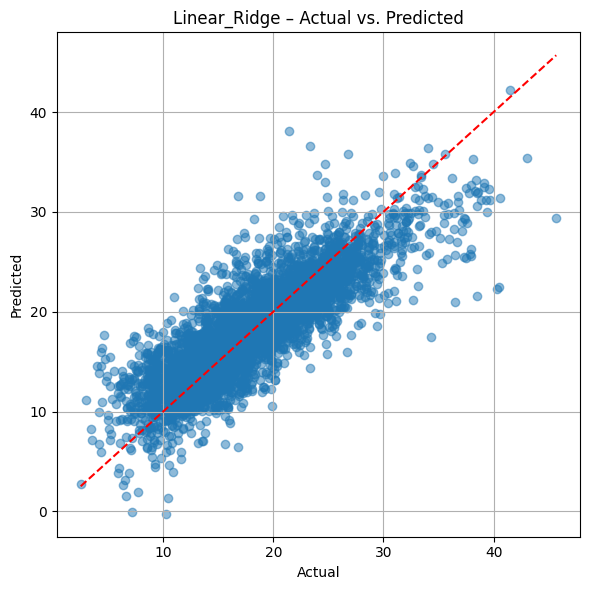

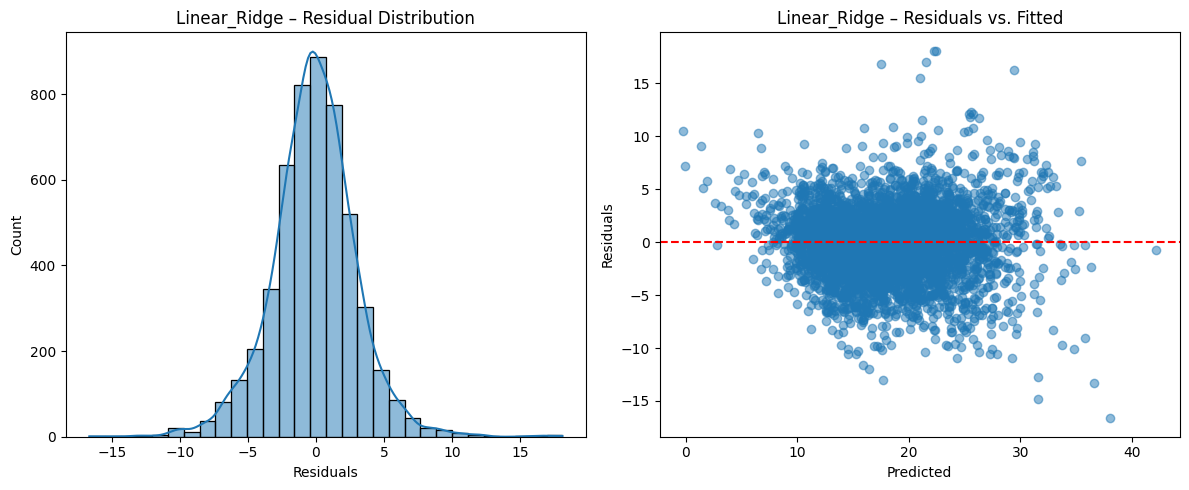

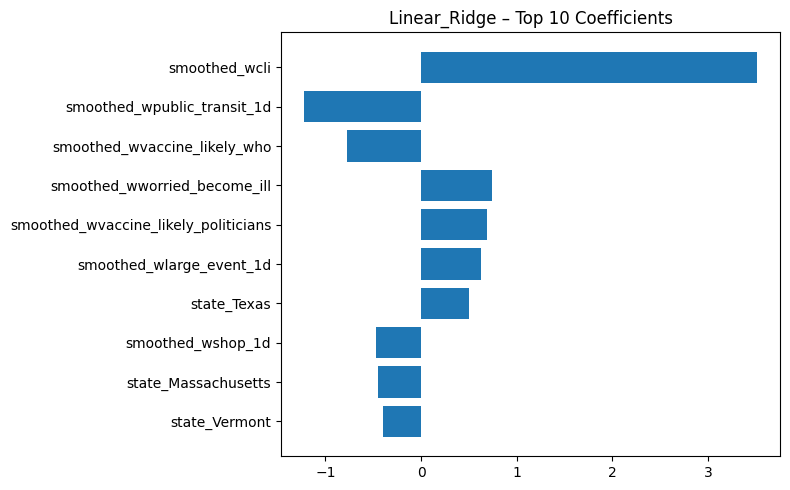


>>> Linear_Lasso - Test Set (Split by is_pseudo_covid_positive): [real=799, proxy=4327]
                             MAE    RMSE      R2
Real Data (is_pseudo=0)   3.7505  4.7268  0.5589
Proxy Data (is_pseudo=1)  2.1028  2.7899  0.7269


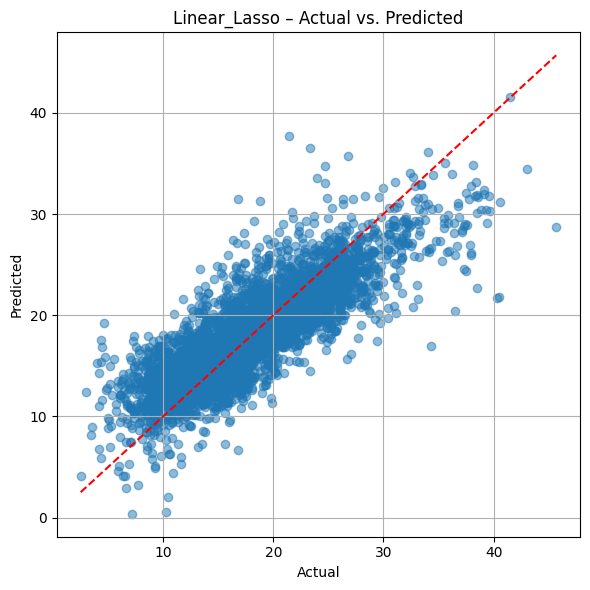

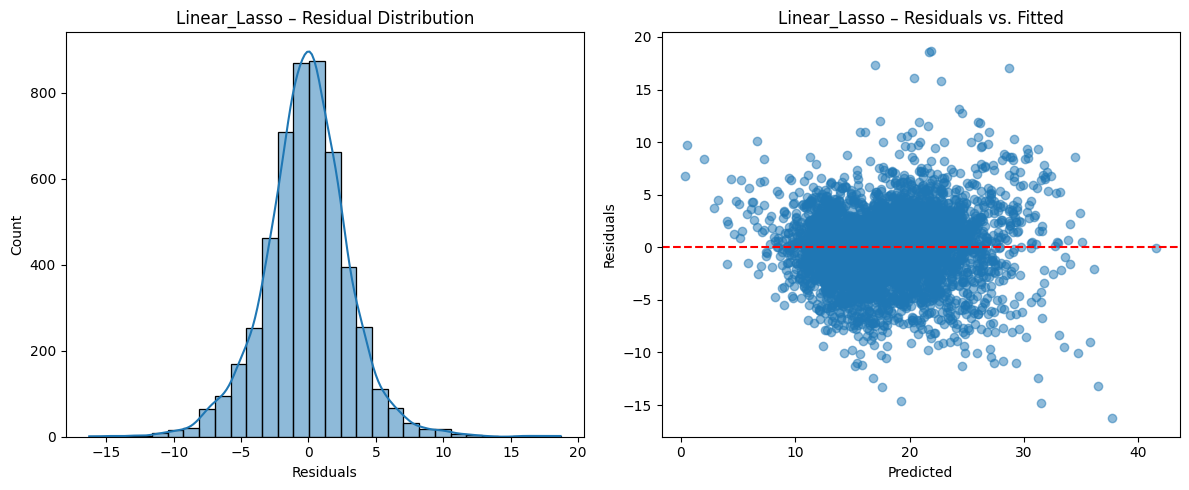

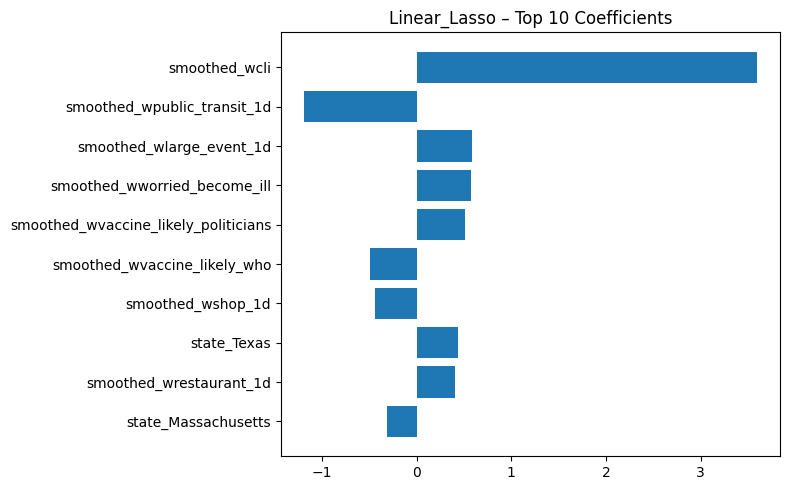


>>> ElasticNet - Test Set (Split by is_pseudo_covid_positive): [real=799, proxy=4327]
                             MAE    RMSE      R2
Real Data (is_pseudo=0)   3.9778  5.0195  0.5026
Proxy Data (is_pseudo=1)  2.3059  3.0152  0.6811


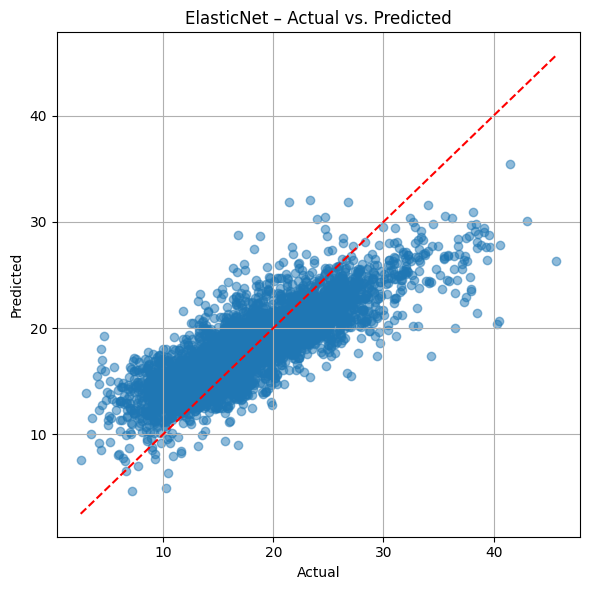

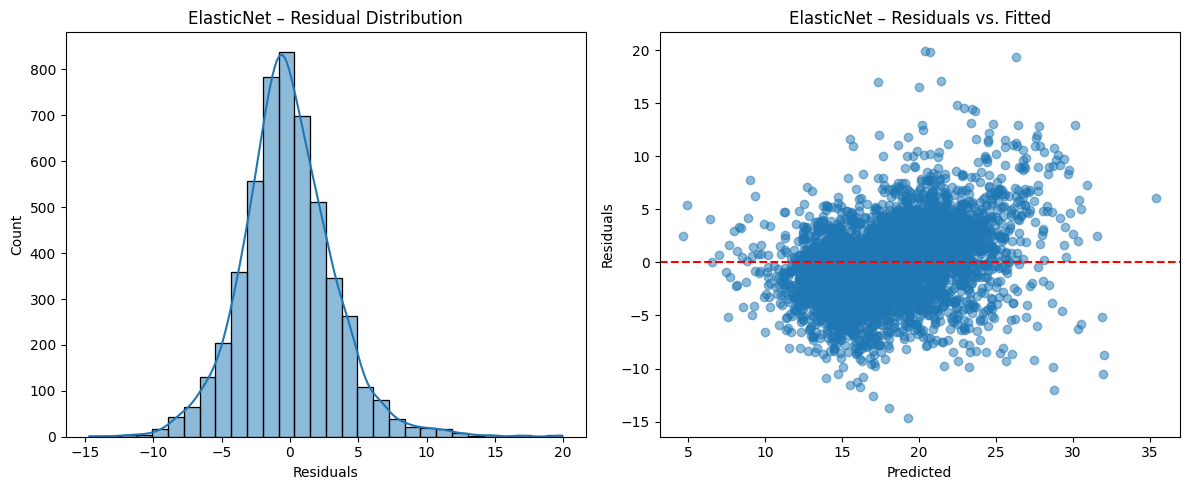

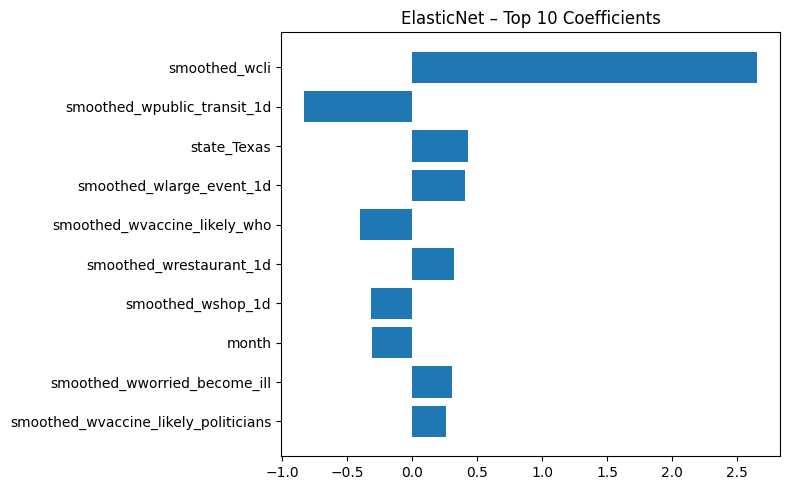

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



>>> NeuralNetwork - Test Set (Split by is_pseudo_covid_positive): [real=799, proxy=4327]
                             MAE    RMSE      R2
Real Data (is_pseudo=0)   2.1751  2.8368  0.8411
Proxy Data (is_pseudo=1)  1.5867  2.0569  0.8516


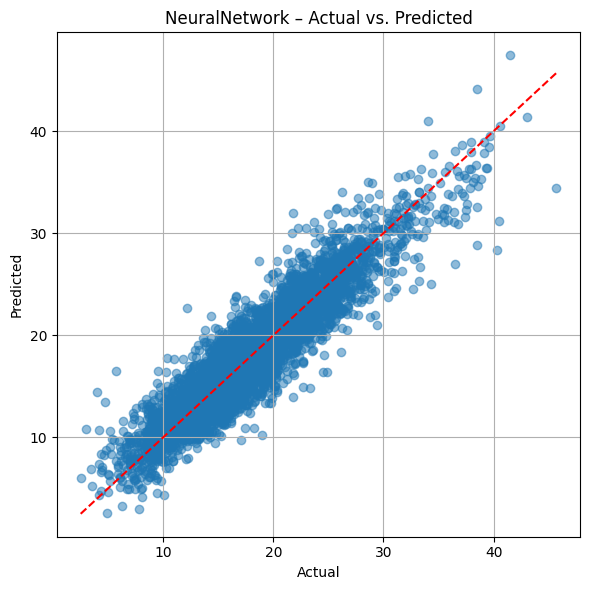

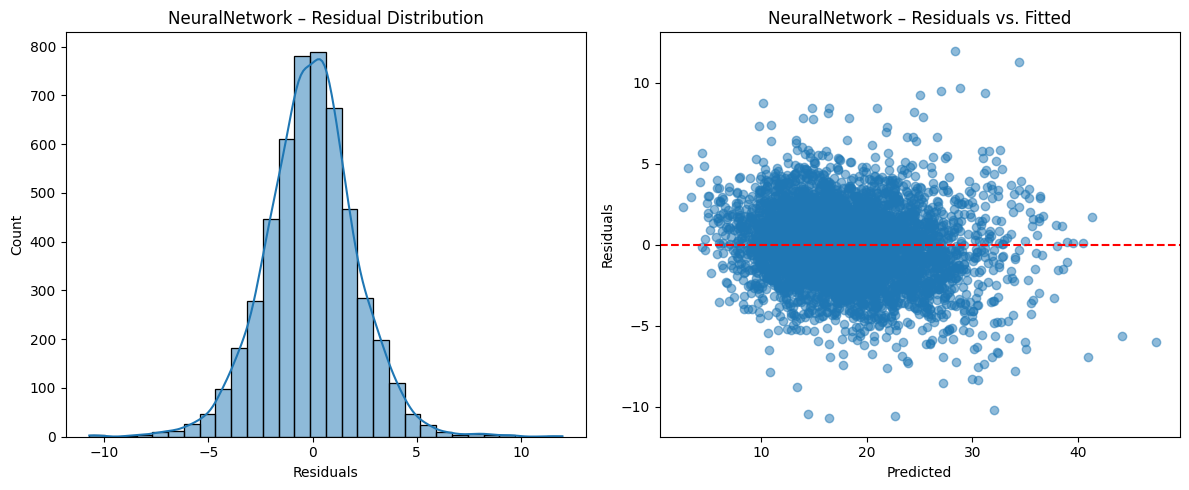

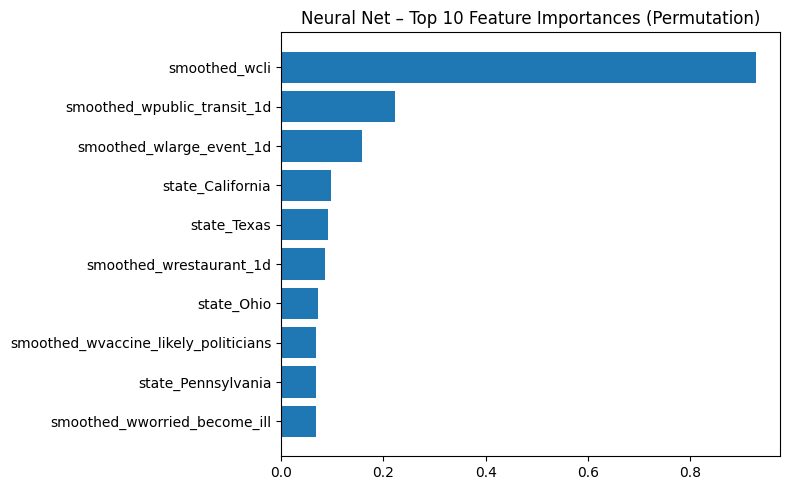


>>> XGBoost - Test Set (Split by is_pseudo_covid_positive): [real=799, proxy=4327]
                             MAE    RMSE      R2
Real Data (is_pseudo=0)   2.2353  2.9442  0.8289
Proxy Data (is_pseudo=1)  0.9356  1.2118  0.9485


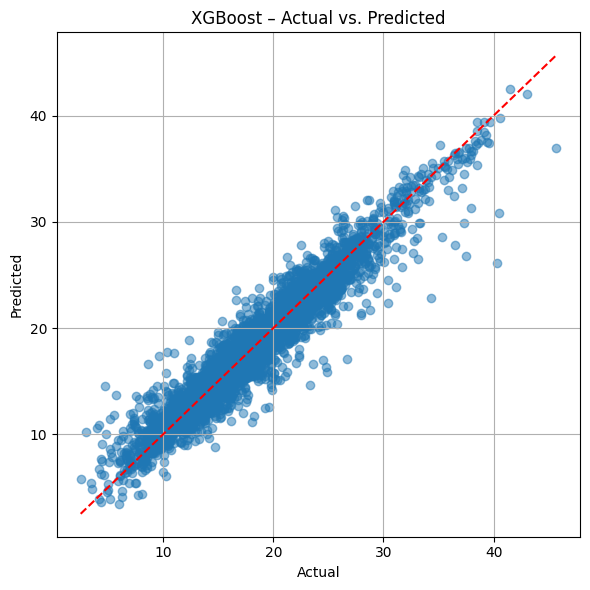

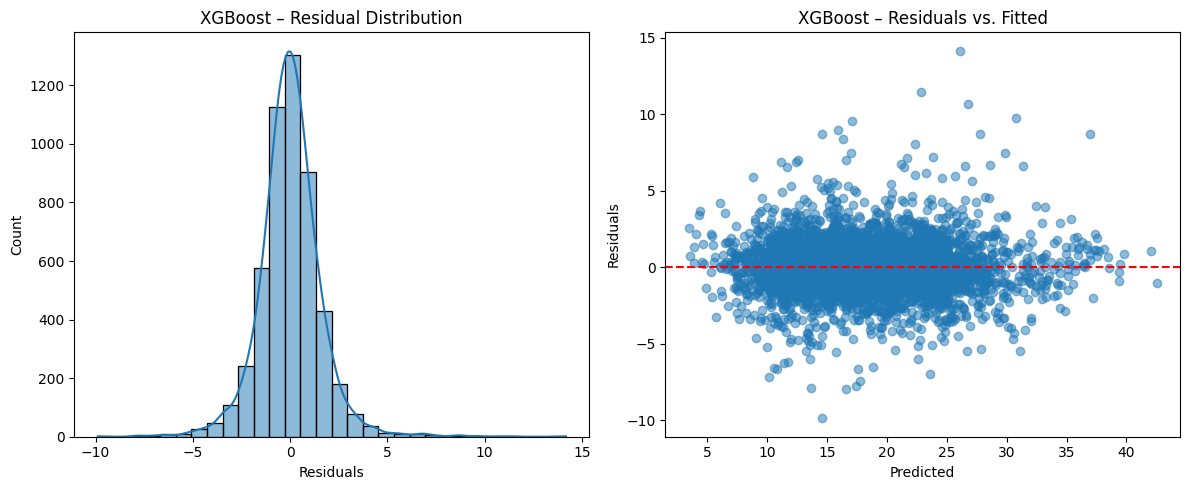

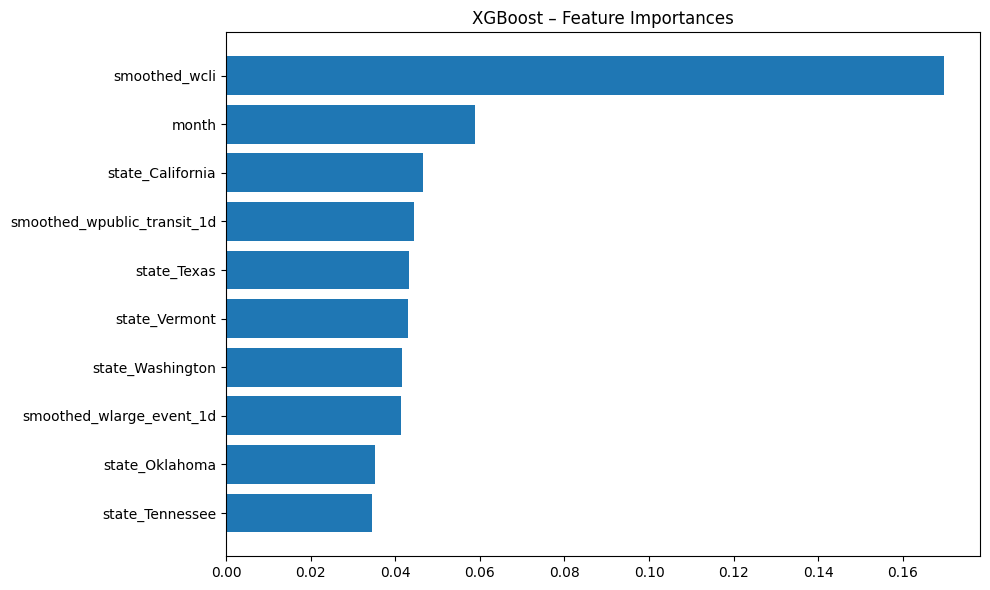

--- Train Data Performance (K-Fold) ---
                           MAE             RMSE               R2
Linear_Ridge   2.3417 ± 0.0186  3.1731 ± 0.0252  0.7042 ± 0.0102
Linear_Lasso   2.3890 ± 0.0202  3.2376 ± 0.0244  0.6921 ± 0.0096
ElasticNet     2.6173 ± 0.0305  3.5048 ± 0.0361  0.6393 ± 0.0067
NeuralNetwork  1.7864 ± 0.0252  2.3441 ± 0.0291  0.8386 ± 0.0067
XGBoost        1.1986 ± 0.0119  1.6973 ± 0.0189  0.9153 ± 0.0039

--- Test Data Performance (Final Evaluation) ---
                  MAE    RMSE      R2
Linear_Ridge   2.3154  3.1045  0.6997
Linear_Lasso   2.3596  3.1706  0.6868
ElasticNet     2.5665  3.4061  0.6386
NeuralNetwork  1.6784  2.1968  0.8497
XGBoost        1.1382  1.6096  0.9193
                  MAE    RMSE      R2
Linear_Ridge   2.3154  3.1045  0.6997
Linear_Lasso   2.3596  3.1706  0.6868
ElasticNet     2.5665  3.4061  0.6386
NeuralNetwork  1.6784  2.1968  0.8497
XGBoost        1.1382  1.6096  0.9193


In [ ]:
df_result = run_pipeline(df, 'smoothed_wtested_positive_14d')
print(df_result)

Comparing with REAL DATA

In [ ]:
df.groupby('is_pseudo_covid_positive')['smoothed_wtested_positive_14d'].describe()


,count,mean,std,min,25%,50%,75%,max
is_pseudo_covid_positive,,,,,,,,
0,3994.0,17.25077,7.419522,1.548609,11.616797,16.530456,22.153012,46.644291
1,21632.0,18.02358,5.446399,5.663007,14.291101,17.158150,21.178679,43.073309


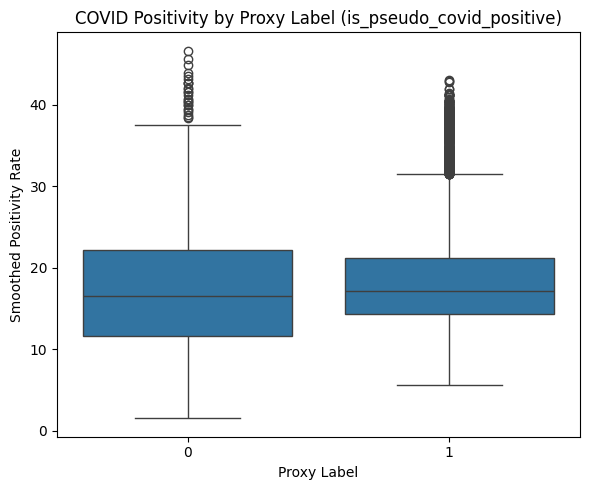

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.boxplot(x='is_pseudo_covid_positive', y='smoothed_wtested_positive_14d', data=df)
plt.title("COVID Positivity by Proxy Label (is_pseudo_covid_positive)")
plt.xlabel("Proxy Label")
plt.ylabel("Smoothed Positivity Rate")
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

group0 = df[df['is_pseudo_covid_positive'] == 0]['smoothed_wtested_positive_14d']
group1 = df[df['is_pseudo_covid_positive'] == 1]['smoothed_wtested_positive_14d']

t_stat, p_val = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")


T-statistic: -6.2778
P-value: 3.7364e-10


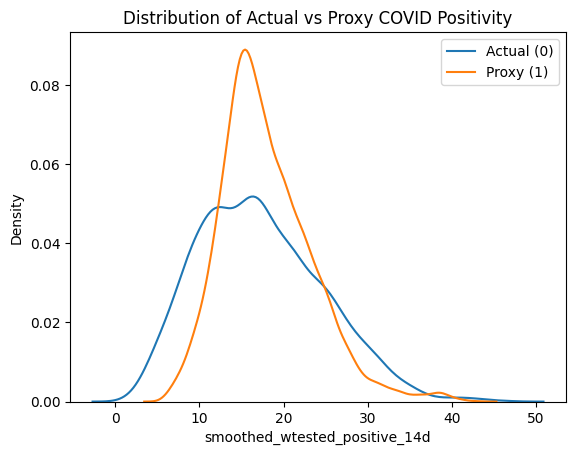

In [ ]:
sns.kdeplot(group0, label="Actual (0)")
sns.kdeplot(group1, label="Proxy (1)")
plt.legend()
plt.title("Distribution of Actual vs Proxy COVID Positivity")
plt.xlabel("smoothed_wtested_positive_14d")
plt.show()


In [ ]:
print("Actual Mean:", group0.mean())
print("Proxy Mean :", group1.mean())


Actual Mean: 17.25076993207311
Proxy Mean : 18.023579708736783
